# MNIST meets RND

In this tutorial, we go over how to apply random network distillation to non-standard network architectures, specifically, the convoltutional neural networks required to classify the MNIST dataset.

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


import znrnd as rnd

import tensorflow_datasets as tfds

import numpy as np
from flax import linen as nn
import optax

from jax.lib import xla_bridge

print(f"Using: {xla_bridge.get_backend().platform}")

/tikhome/knikolaou/miniconda3/envs/jax/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2022-09-15 16:10:09.538744: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/tikhome/knikolaou/miniconda3/envs/jax/lib/python3.10/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


Using: cpu


### Making a data generator

The first thing we need to do is create a data generator for the problem.

In [2]:
data_generator = rnd.data.MNISTGenerator()

2022-09-15 16:10:12.037247: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 100%|█████████████████████████| 4/4 [00:00<00:00,  4.30 file/s]
2022-09-15 16:10:15.019658: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


### Define the agent

In [3]:
class CustomModule(nn.Module):
    """
    Simple CNN module.
    """
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=256)(x)
        return x

In [4]:
class ProductionModule(nn.Module):
    """
    Simple CNN module.
    """

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=128, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(3, 3), strides=(2, 2))
        x = nn.Conv(features=128, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(3, 3), strides=(2, 2))
        x = x.reshape((x.shape[0], -1))  # flatten
        x = nn.Dense(features=300)(x)
        x = nn.relu(x)
        x = nn.Dense(10)(x)

        return x

In [6]:
production_model = rnd.models.FlaxModel(
            flax_module=ProductionModule(),
            optimizer=optax.adam(learning_rate=0.01),
            loss_fn=rnd.loss_functions.CrossEntropyLoss(),
            input_shape=(1, 28, 28, 1),
            training_threshold=0.001,
            accuracy_fn=rnd.accuracy_functions.LabelAccuracy()
        )

In [7]:
_ = production_model.train_model(
    train_ds={"inputs": data_generator.train_ds["inputs"], "targets": data_generator.train_ds["targets"]},
    test_ds={"inputs": data_generator.test_ds["inputs"], "targets": data_generator.test_ds["targets"]},
    batch_size=32,
)

Epoch: 1:   0%|                                                           | 0/50 [00:00<?, ?batch/s]/tikhome/knikolaou/work/Repositories/ZnRND/znrnd/models/flax_model.py:388: FutureWarning: jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.
  summary = jax.tree_map(lambda x: x.item(), metrics)
Epoch: 50: 100%|█████████████████████████████████| 50/50 [02:25<00:00,  2.90s/batch, accuracy=0.916]


In [8]:
target = rnd.models.FlaxModel(
        flax_module=CustomModule(),
        optimizer=optax.adam(learning_rate=0.001),
        loss_fn=rnd.loss_functions.MeanPowerLoss(order=2),
        input_shape=(1, 28, 28, 1),
        training_threshold=0.001
    )

predictor = rnd.models.FlaxModel(
        flax_module=CustomModule(),
        optimizer=optax.adam(learning_rate=0.001),
        loss_fn=rnd.loss_functions.MeanPowerLoss(order=2),
        input_shape=(1, 28, 28, 1),
        training_threshold=0.001
    )

In [9]:
agent = rnd.agents.RND(
        point_selector=rnd.point_selection.GreedySelection(threshold=0.01),
        distance_metric=rnd.distance_metrics.OrderNDifference(order=2),
        data_generator=data_generator,
        target_network=target,
        predictor_network=predictor,
        tolerance=8,
    )

/tikhome/knikolaou/miniconda3/envs/jax/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

/tikhome/knikolaou/miniconda3/envs/jax/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.

Epoch: 1:   0%|                                                           | 0/10 [00:00<?, ?batch/s]/tikhome/knikolaou/work/Repositories/ZnRND/znrnd/models/flax_model.py:388: FutureWarning:

jax.tree_map is deprecated, and will be removed in a future release. Use jax.tree_util.tree_map instead.

Epoch: 11: 100%|█████████████████████████████| 11/11 [00:00<00:00, 30.82batch/s, test_loss=0.000224]
/tikhome/knikolaou/miniconda3/envs/jax/lib/python3.10/site-packages/sklearn/manifold/_t_

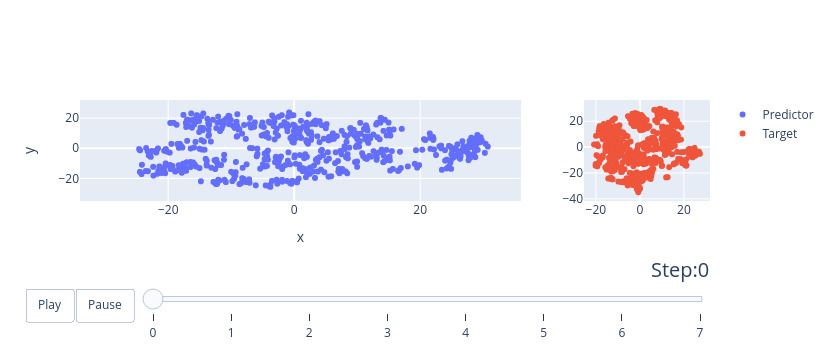

In [12]:
ds = agent.build_dataset(target_size=5, visualize=True)

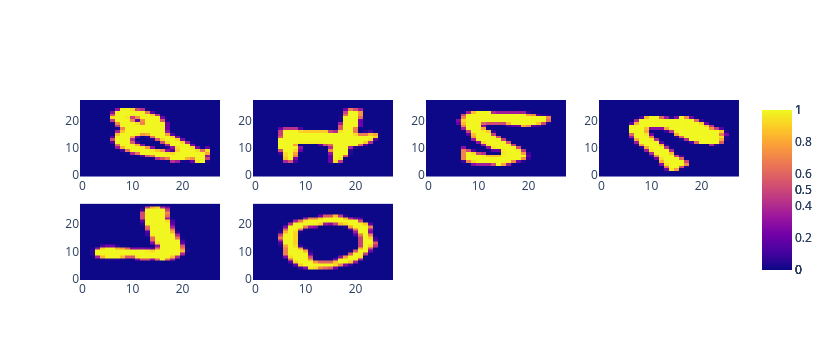

In [13]:
data_generator.plot_image(data_list=np.array(agent.target_set))